In [1]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

In [4]:
def pam_symbol_error_rate(M, Iavg, noise):
    const = (M-1)/M
    x = Iavg / ((M-1)*noise * np.sqrt(2))
    return const * erfc(x)

def pam_bit_error_rate(M, Iavg, noise):
    return pam_symbol_error_rate(M, Iavg, noise) / np.log2(M)

def max_current(power):
    responsivity = 1.0  # resposivity in A/W
    return responsivity * power

def avg_current(power):
    return max_current(power) / 2  # 3 dB penalty because of PAM modulation

def calculate_noise(M, bandwidth, power):

    temp = 300  # temperature in K
    noise_fig = 3  # noise figure of amplifier stage in dB, ideal
    resistance = 2000  # in Ohm
    RIN = -135  # dB/Hz

    # constants
    kB = 1.380649e-23  # Boltzmann constant, J/K
    q = 1.60217662e-19  # electronic charge, C

    # Note the transmission rate is M * bandwidth
    I = max_current(power)
    abs_noise_fig = np.power(10, noise_fig / 10)
    abs_rin = np.power(10, RIN/10)

    # Calculate the individual noise**2
    thermal_noise = 4 * kB * temp * abs_noise_fig * bandwidth / resistance
    shot_noise = 2 * q * I * bandwidth
    laser_noise = abs_rin * I**2 * bandwidth

    noise = thermal_noise + shot_noise + laser_noise
    return np.sqrt(noise)  # amplitude, not power



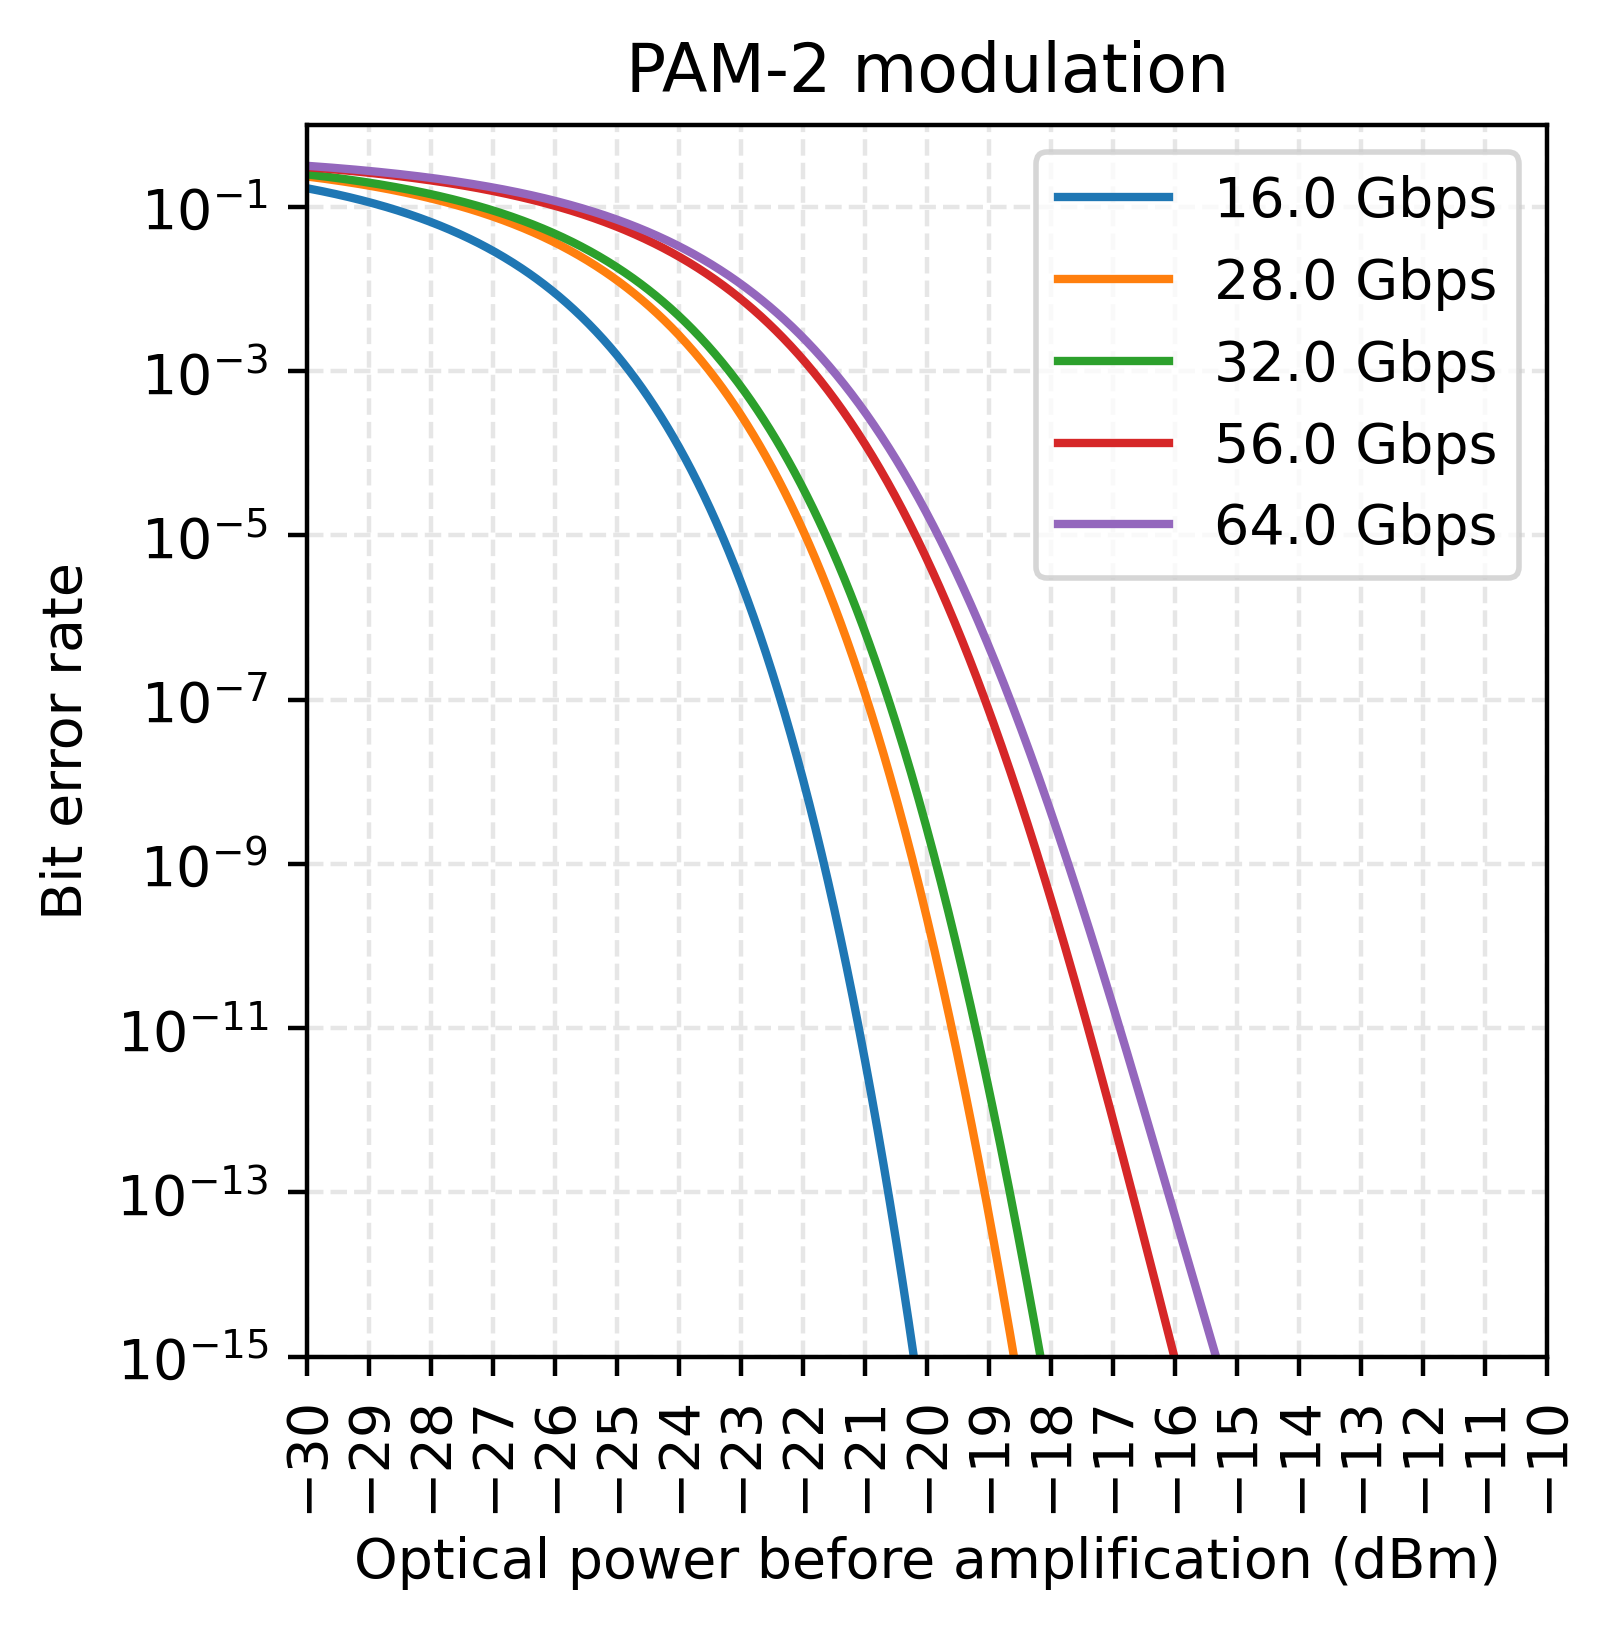

In [5]:
#Laser power in 

laser_power_dBm = np.linspace(-30, -10, 1001)
laser_power = 1e-3 * np.power(10, laser_power_dBm/10, dtype=np.float64)

M = 2
bandwidth = np.array([16, 28, 32, 56, 64]) # in GHz
error_rate = []

for bw in bandwidth:
    noise = calculate_noise(M, bw * 1e9, laser_power)
    Iavg = avg_current(laser_power)
    ber = pam_bit_error_rate(M, Iavg, noise)
    error_rate.append(ber)

error_rate = np.array(error_rate)
labels = [f"{bw*np.log2(M)} Gbps" for bw in bandwidth]

plt.figure(figsize=(4, 4), dpi=400)
plt.semilogy(laser_power_dBm, error_rate.T, label=labels)
# plt.yticks(np.logspace(0, -16, 17))
plt.ylim(1e-15, 1)
plt.ylabel('Bit error rate')
plt.xticks(np.arange(min(laser_power_dBm), max(laser_power_dBm)+1, 1), rotation=90)
plt.xlabel('Optical power before amplification (dBm)')
plt.xlim(min(laser_power_dBm), max(laser_power_dBm))
plt.legend(loc='upper right')
plt.title(f"PAM-{M} modulation")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()

In [6]:
# Estimate the minimum power 
cutoff_error = 1e-15

for i, bw in enumerate(bandwidth):
    idx = np.argwhere(error_rate[i] >= cutoff_error)[-1]
    l_power = laser_power_dBm[idx][0]
    print(f"To achieve {cutoff_error} error, for {bw} GHz bandwidth, need {l_power:.2f} dBm")


To achieve 1e-15 error, for 16 GHz bandwidth, need -20.22 dBm
To achieve 1e-15 error, for 28 GHz bandwidth, need -18.60 dBm
To achieve 1e-15 error, for 32 GHz bandwidth, need -18.18 dBm
To achieve 1e-15 error, for 56 GHz bandwidth, need -16.02 dBm
To achieve 1e-15 error, for 64 GHz bandwidth, need -15.36 dBm


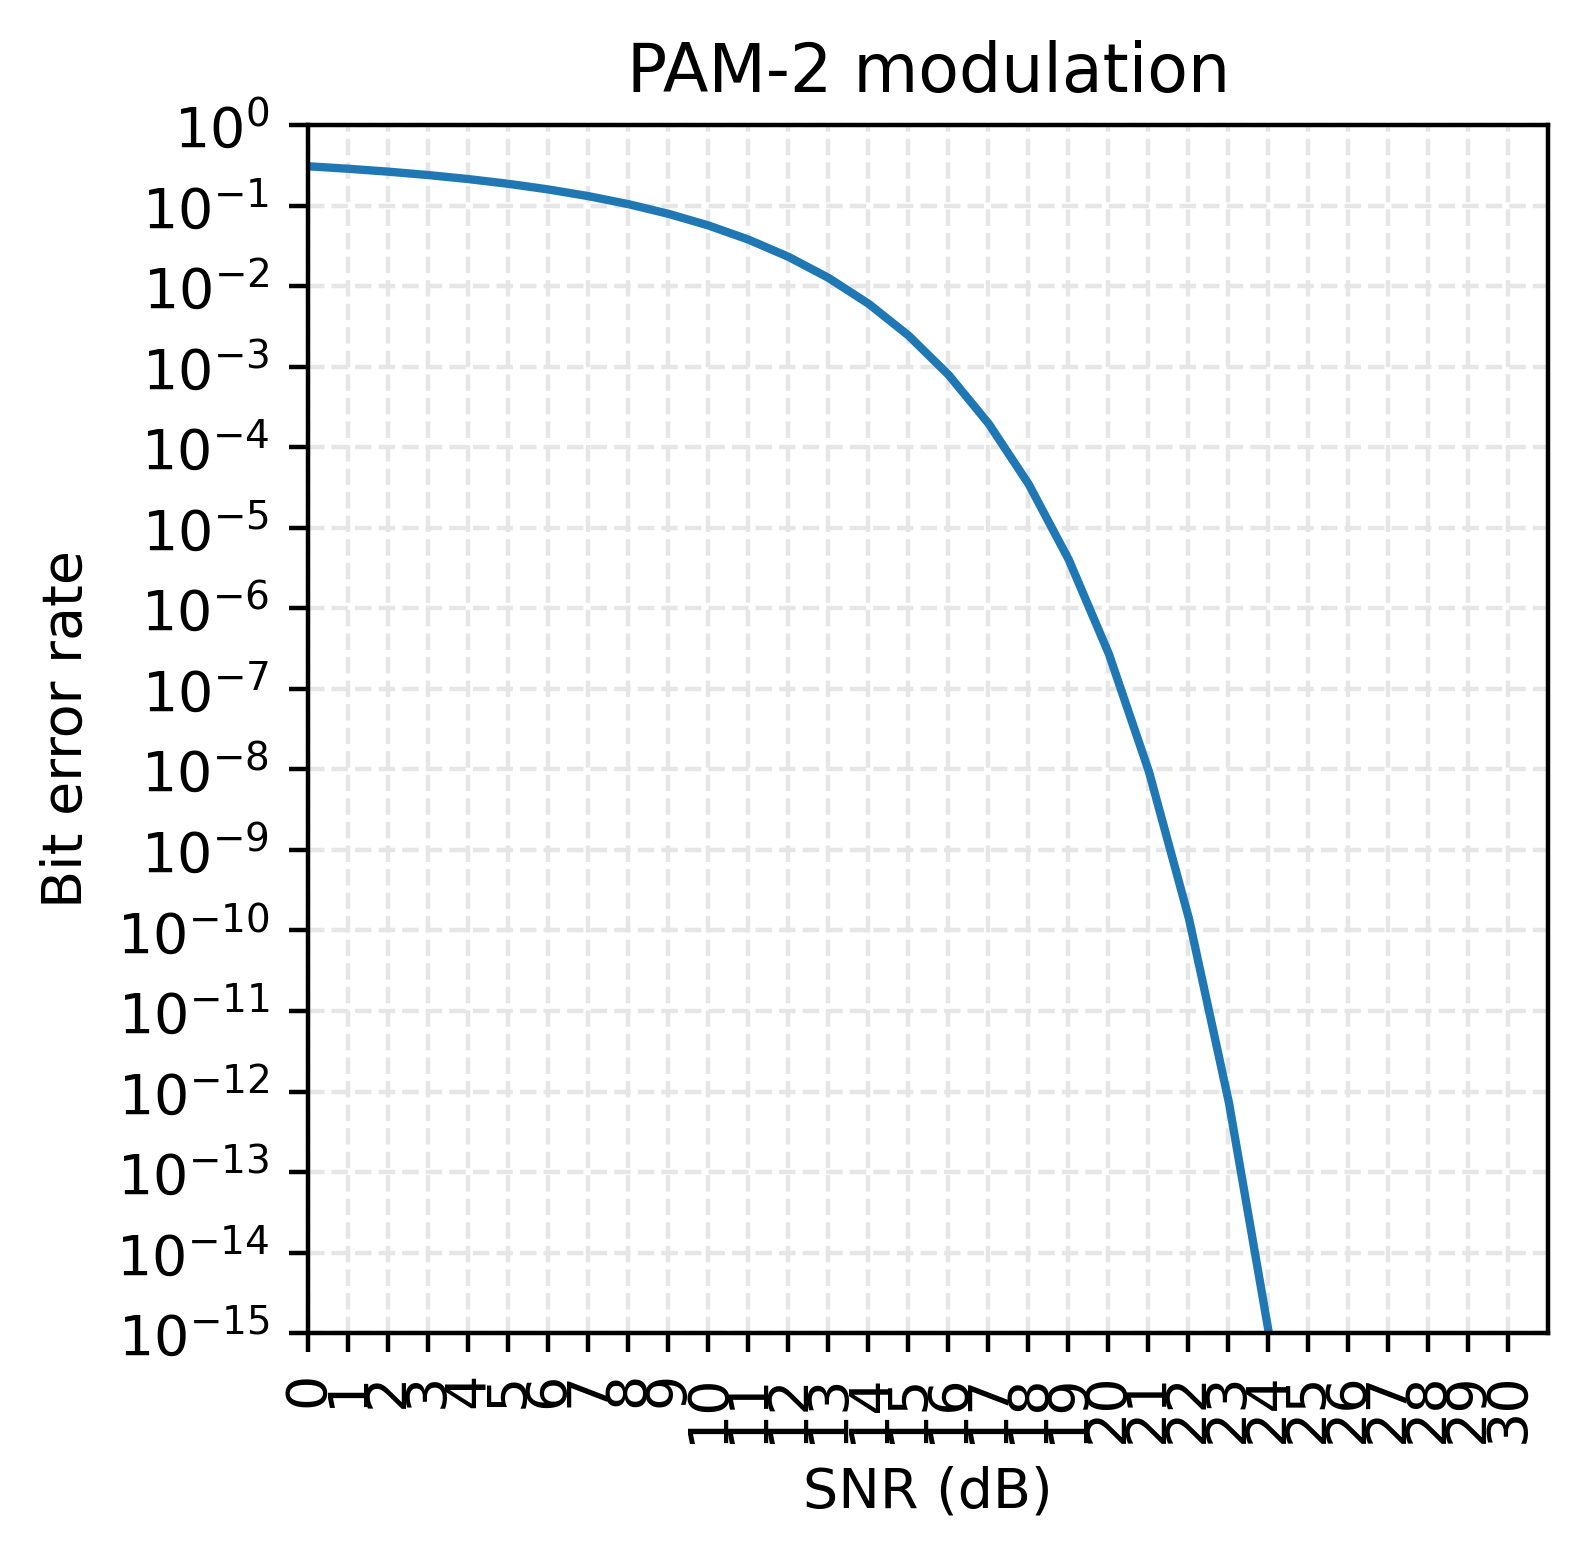

In [57]:
# Looking at BER vs. SNR
snr = np.linspace(0, 1001, 1001)  # in dB
error_rate = []

# note: snr = i**2 / noise**2
snr_ = np.power(10, snr/10)
Q = np.sqrt(snr_) / 2
ber = pam_bit_error_rate(M, Q, 1.0)

plt.figure(figsize=(4, 4), dpi=400)
plt.semilogy(snr, ber)
plt.yticks(np.logspace(0, -25, 26))
plt.ylim(1e-15, 1)
plt.ylabel('Bit error rate')
plt.xticks(np.arange(min(snr), 30 + 1, 1), rotation=90)
plt.xlabel('SNR (dB)')
plt.xlim(min(snr), 31)
# plt.legend(loc='upper right')
plt.title(f"PAM-{M} modulation")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()

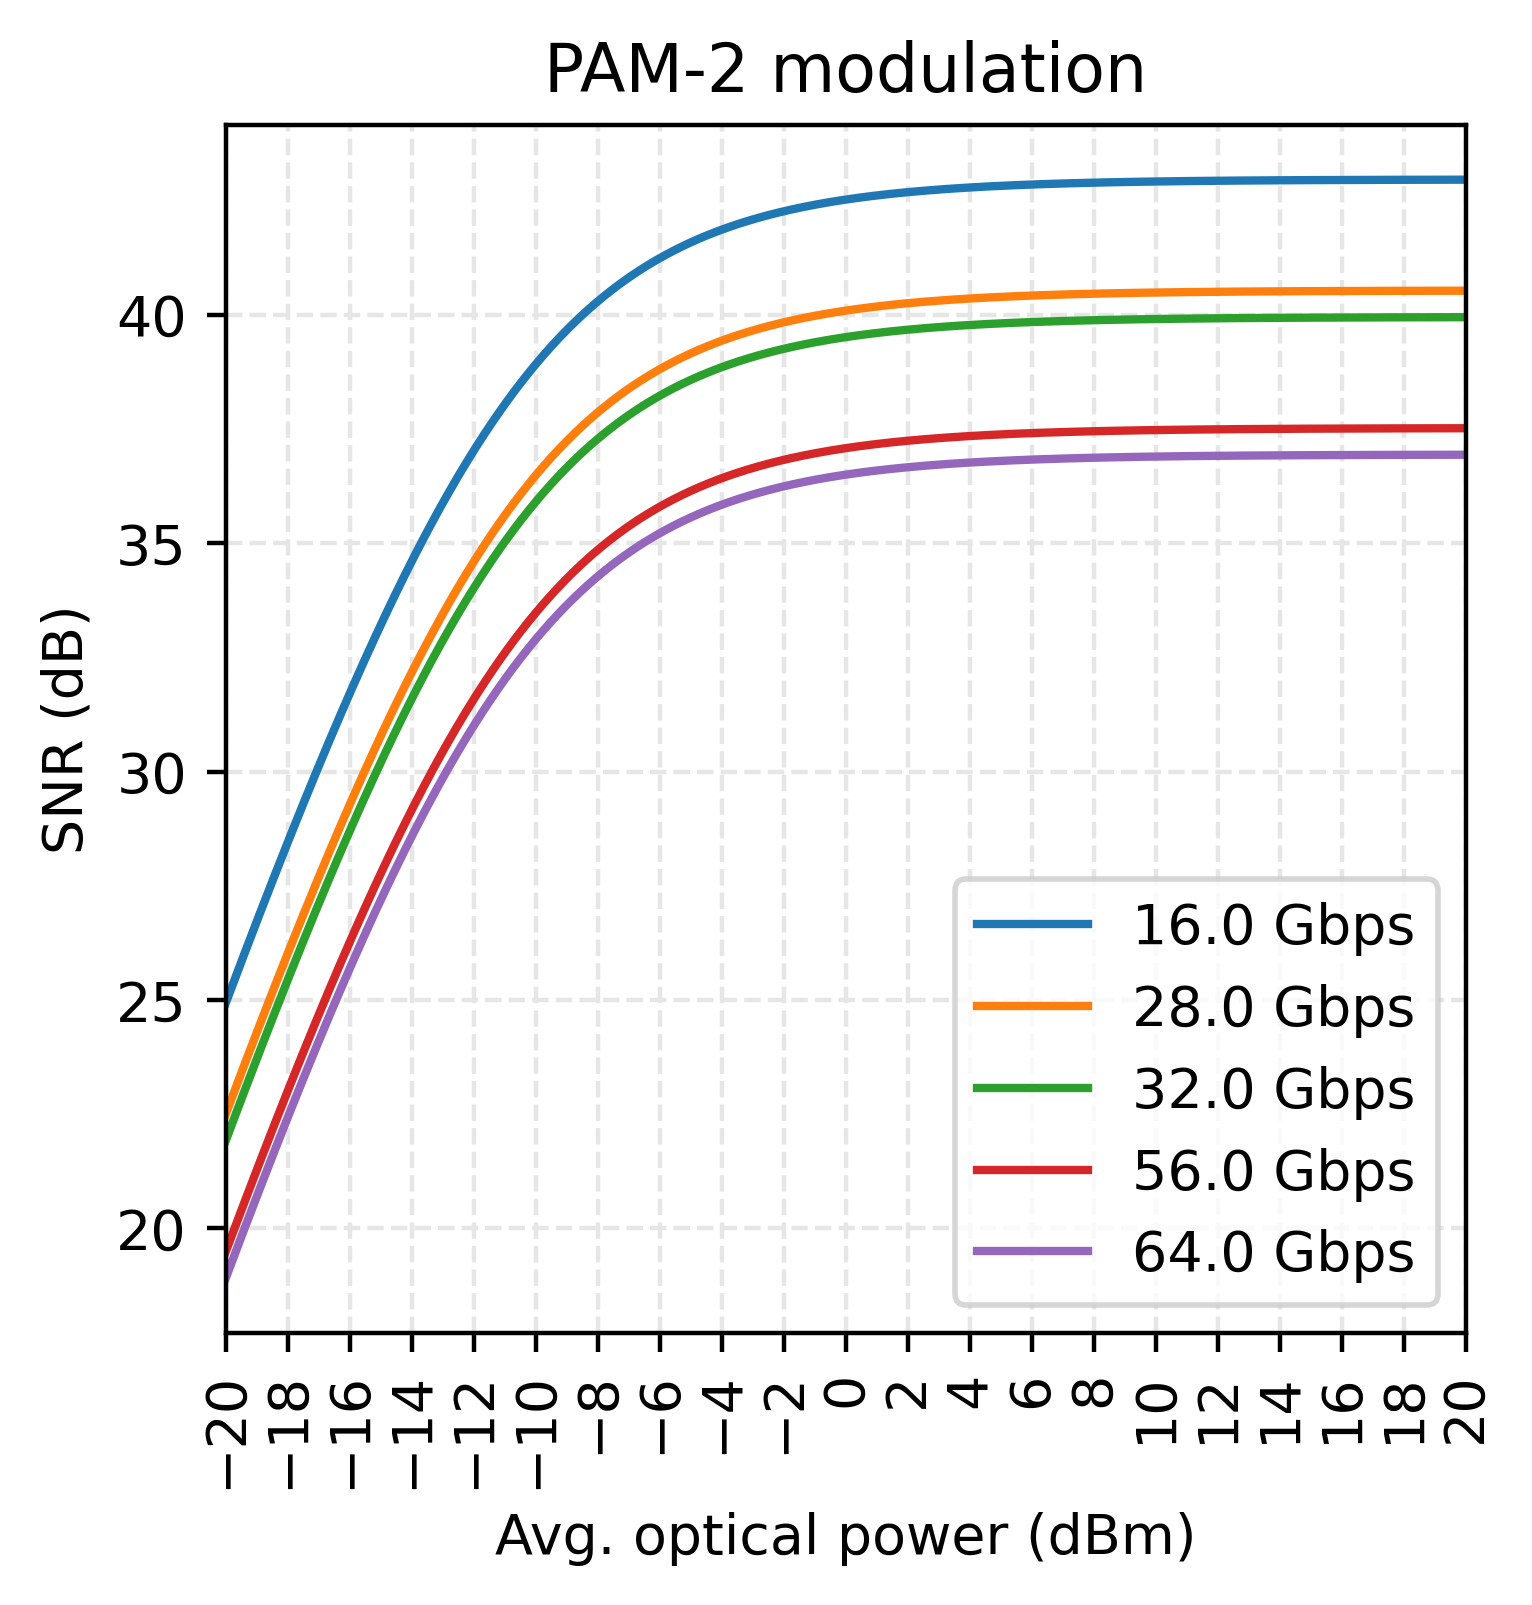

In [58]:
laser_power_dBm = np.linspace(-20, 20, 1001)
laser_power = 1e-3 * np.power(10, laser_power_dBm / 10, dtype=np.float64)

M = 2
bandwidth = np.array([16, 28, 32, 56, 64])  # in GHz

snr = []

for bw in bandwidth:
    noise = calculate_noise(M, bw * 1e9, laser_power)
    I = max_current(laser_power)
    snr.append(I**2/noise**2)

snr = np.array(snr)
snr = 10*np.log10(snr)  # in dB
labels = [f"{bw*np.log2(M)} Gbps" for bw in bandwidth]

plt.figure(figsize=(4, 4), dpi=400)
plt.plot(laser_power_dBm, snr.T, label=labels)
# plt.yticks(np.arange(15, 50, 1))
# plt.ylim(15, 21)
plt.ylabel('SNR (dB)')
plt.xticks(np.arange(min(laser_power_dBm),
                     max(laser_power_dBm) + 1, 2),
           rotation=90)
plt.xlabel('Avg. optical power (dBm)')
plt.xlim(min(laser_power_dBm), max(laser_power_dBm))
plt.legend(loc='lower right')
plt.title(f"PAM-{M} modulation")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()